# 6.2 Convolutions for Images
Now that we understand how convolutional layers work in theory, we are ready to see how they
work in practice. Building on our motivation of convolutional neural networks as efficient architectures for exploring structure in image data, we stick with images as our running example.
## 6.2.1 The Cross-Correlation Operation
Recall that strictly speaking, convolutional layers are a misnomer, since the operations they express are more accurately described as cross-correlations. Based on our descriptions of convolutional layers in Section 6.1, in such a layer, an input tensor and a kernel tensor are combined to
produce an output tensor through a cross-correlation operation.

Let us ignore channels for now and see how this works with two-dimensional data and hidden
representations. In Fig. 6.2.1, the input is a two-dimensional tensor with a height of 3 and width
of 3. We mark the shape of the tensor as 3 × 3 or (3, 3). The height and width of the kernel are
both 2. The shape of the kernel window (or convolution window) is given by the height and width of
the kernel (here it is 2 × 2).

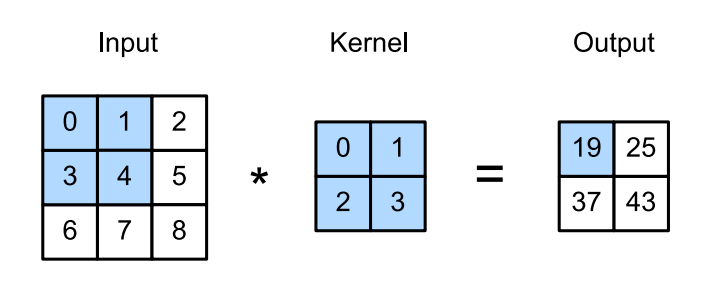

Fig. 6.2.1: Two-dimensional cross-correlation operation. The shaded portions are the first output
element as well as the input and kernel tensor elements used for the output computation: 0 × 0 +
1 × 1 + 3 × 2 + 4 × 3 = 19.

In the two-dimensional cross-correlation operation, we begin with the convolution window positioned at the top-left corner of the input tensor and slide it across the input tensor, both from leff to right and top to bottom. When the convolution window slides to a certain position, the input
subtensor contained in that window and the kernel tensor are multiplied elementwise and the resulting tensor is summed up yielding a single scalar value. This result gives the value of the output
tensor at the corresponding location. Here, the output tensor has a height of 2 and width of 2 and
the four elements are derived from the two-dimensional cross-correlation operation:

$$

0 × 0 + 1 × 1 + 3 × 2 + 4 × 3 = 19,\\
1 × 0 + 2 × 1 + 4 × 2 + 5 × 3 = 25,\\
3 × 0 + 4 × 1 + 6 × 2 + 7 × 3 = 37,\\
4 × 0 + 5 × 1 + 7 × 2 + 8 × 3 = 43.\\
(6.2.1)

$$

Note that along each axis, the output size is slightly smaller than the input size. Because the kernel
has width and height greater than one, we can only properly compute the cross-correlation for
locations where the kernel fits wholly within the image, the output size is given by the input size
$n_h × n_w$ minus the size of the convolution kernel $k_h × k_w$ via

$$(n_h − k_h + 1) × (n_w − k_w + 1). (6.2.2)$$

This is the case since we need enough space to “shift” the convolution kernel across the image.
Later we will see how to keep the size unchanged by padding the image with zeros around its
boundary so that there is enough space to shift the kernel. Next, we implement this process in
the corr2d function, which accepts an input tensor X and a kernel tensor K and returns an output
tensor Y.

In [ ]:
from mxnet import autograd, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()

In [ ]:
def corr2d(X, K): #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

We can construct the input tensor X and the kernel tensor K from Fig. 6.2.1 to validate the output
of the above implementation of the two-dimensional cross-correlation operation.

In [ ]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

## 6.2.2 Convolutional Layers
A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an
output. The two parameters of a convolutional layer are the kernel and the scalar bias. When
training models based on convolutional layers, we typically initialize the kernels randomly, just
as we would with a fully-connected layer.
We are now ready to implement a two-dimensional convolutional layer based on the corr2d function defined above. In the __init__ constructor function, we declare weight and bias as the two
model parameters. The forward propagation function calls the corr2d function and adds the bias.

In [ ]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))
        
    def forward(self, x):
        return corr2d(x, self.weight.data()) + self.bias.data()


In $h × w$ convolution or a $h × w$ convolution kernel, the height and width of the convolution kernel
are $h$ and $w$, respectively. We also refer to a convolutional layer with a $h × w$ convolution kernel
simply as a $h × w$ convolutional layer.

## 6.2.3 Object Edge Detection in Images
Let us take a moment to parse a simple application of a convolutional layer: detecting the edge of
an object in an image by finding the location of the pixel change. First, we construct an “image”
of 6 × 8 pixels. The middle four columns are black (0) and the rest are white (1).

In [ ]:
X = np.ones((6, 8))
X[:, 2:6] = 0
X

Next, we construct a kernel K with a height of 1 and a width of 2. When we perform the crosscorrelation operation with the input, if the horizontally adjacent elements are the same, the output
is 0. Otherwise, the output is non-zero

In [ ]:
K = np.array([[1.0, -1.0]])

We are ready to perform the cross-correlation operation with arguments X (our input) and K (our
kernel). As you can see, we detect 1 for the edge from white to black and -1 for the edge from black
to white. All other outputs take value 0.

In [ ]:
Y = corr2d(X, K)
Y

We can now apply the kernel to the transposed image. As expected, it vanishes. The kernel K only
detects vertical edges.

In [ ]:
corr2d(X.T, K)

## 6.2.4 Learning a Kernel
Designing an edge detector by finite differences [1, -1] is neat if we know this is precisely what
we are looking for. However, as we look at larger kernels, and consider successive layers of convolutions, it might be impossible to specify precisely what each filter should be doing manually.

Now let us see whether we can learn the kernel that generated Y from X by looking at the input–
output pairs only. We first construct a convolutional layer and initialize its kernel as a random
tensor. Next, in each iteration, we will use the squared error to compare Y with the output of
the convolutional layer. We can then calculate the gradient to update the kernel. For the sake of
simplicity, in the following we use the built-in class for two-dimensional convolutional layers and
ignore the bias.

In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2D(1, kernel_size=(1, 2), use_bias=False)
conv2d.initialize()

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)
lr = 3e-2 # Learning rate

for i in range(10):
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat - Y)**2
    l.backward()
    # Update the kernel
    conv2d.weight.data()[:] -= lr * conv2d.weight.grad()
    if (i + 1) % 2 == 0:
        print(f'batch {i + 1}, loss {float(l.sum()):.3f}')


Note that the error has dropped to a small value after 10 iterations. Now we will take a look at the
kernel tensor we learned.

In [ ]:
conv2d.weight.data().reshape((1, 2))

Indeed, the learned kernel tensor is remarkably close to the kernel tensor K we defined earlier.

## 6.2.5 Cross-Correlation and Convolution
Recall our observation from Section 6.1 of the correspondence between the cross-correlation and
convolution operations. Here let us continue to consider two-dimensional convolutional layers.
What if such layers perform strict convolution operations as defined in (6.1.6) instead of crosscorrelations? In order to obtain the output of the strict convolution operation, we only need to flip
the two-dimensional kernel tensor both horizontally and vertically, and then perform the crosscorrelation operation with the input tensor.

It is noteworthy that since kernels are learned from data in deep learning, the outputs of convolutional layers remain unaffected no matter such layers perform either the strict convolution
operations or the cross-correlation operations.

To illustrate this, suppose that a convolutional layer performs cross-correlation and learns the kernel in Fig. 6.2.1, which is denoted as the matrix **K** here. Assuming that other conditions remain
unchanged, when this layer performs strict convolution instead, the learned kernel **K′** will be the same as **K** after **K′** is flipped both horizontally and vertically. That is to say, when the convolutional layer performs strict convolution for the input in Fig. 6.2.1 and **K′**, the same output in Fig. 6.2.1 (cross-correlation of the input and **K**) will be obtained.

In keeping with standard terminology with deep learning literature, we will continue to refer to the
cross-correlation operation as a convolution even though, strictly-speaking, it is slightly different.
Besides, we use the term element to refer to an entry (or component) of any tensor representing a
layer representation or a convolution kernel.

## 6.2.6 Feature Map and Receptive Field
As described in Section 6.1.4, the convolutional layer output in Fig. 6.2.1 is sometimes called a *feature map*, as it can be regarded as the learned representations (features) in the spatial dimensions
(e.g., width and height) to the subsequent layer. In CNNs, for any element x of some layer, its *receptive field* refers to all the elements (from all the previous layers) that may affect the calculation
of x during the forward propagation. Note that the receptive field may be larger than the actual
size of the input.

Let us continue to use Fig. 6.2.1 to explain the receptive field. Given the 2 × 2 convolution kernel,
the receptive field of the shaded output element (of value 19) is the four elements in the shaded
portion of the input. Now let us denote the 2 × 2 output as **Y** and consider a deeper CNN with an
additional 2 × 2 convolutional layer that takes **Y** as its input, outputting a single element z. In this
case, the receptive field of z on **Y** includes all the four elements of **Y**, while the receptive field on
the input includes all the nine input elements. Thus, when any element in a feature map needs a
larger receptive field to detect input features over a broader area, we can build a deeper network.

## Summary
* The core computation of a two-dimensional convolutional layer is a two-dimensional crosscorrelation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.
* We can design a kernel to detect edges in images.
* We can learn the kernelʼs parameters from data.
* With kernels learned from data, the outputs of convolutional layers remain unaffected regardless of such layersʼ performed operations (either strict convolution or crosscorrelation).
* When any element in a feature map needs a larger receptive field to detect broader features on the input, a deeper network can be considered.
